In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr



/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
expected_ds = xr.open_dataset('./output/expected_synthetic_data63_2025-03-14.nc')
expected_ds

<xarray.Dataset> Size: 243kB
Dimensions:       (time: 1080, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2025-03-14T11:10:54 ... 2025-03-1...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables: (12/13)
    dcdt(HM)      (time, cutoff) float64 138kB ...
    deadband      (time) int64 9kB ...
    d_intensity   (time) int64 9kB ...
    d_startpoint  (time) int64 9kB ...
    add_noise     (time) bool 1kB ...
    c0            (time) int64 9kB ...
    ...            ...
    cs            (time) float64 9kB ...
    pressure      (time) float64 9kB ...
    temperature   (time) float64 9kB ...
    humidity      (time) float64 9kB ...
    area          (time) float64 9kB ...
    volume        (time) float64 9kB ...

In [35]:
ds = xr.open_dataset('./output/synthetic_data63_2025-03-14.nc')
ds

<xarray.Dataset> Size: 5MB
Dimensions:       (time: 1080, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2025-03-14T11:10:54 ... 2025-03-1...
  * deadband      (deadband) int32 24B 0 10 20 30 40 50
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 829kB ...
    dcdt(linear)  (time, cutoff, deadband) float64 829kB ...
    AIC(HM)       (time, cutoff, deadband) float64 829kB ...
    AIC(linear)   (time, cutoff, deadband) float64 829kB ...
    RMSE(HM)      (time, cutoff, deadband) float64 829kB ...
    RMSE(linear)  (time, cutoff, deadband) float64 829kB ...

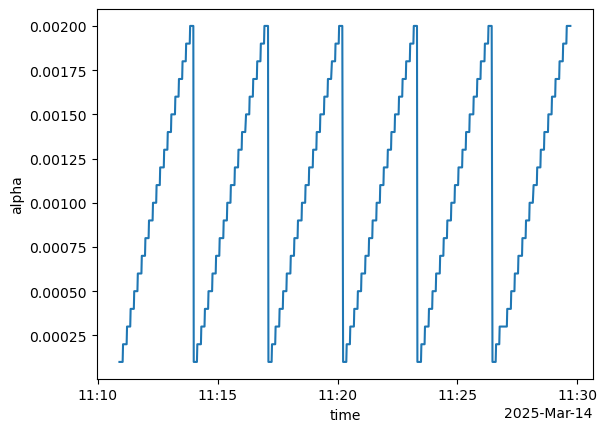

In [36]:
expected_ds['alpha'].plot()

In [37]:
np.unique(expected_ds['d_startpoint'].values)

array([  0,  30,  60,  90, 150, 170])

In [38]:
print(expected_ds)

<xarray.Dataset> Size: 243kB
Dimensions:       (time: 1080, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2025-03-14T11:10:54 ... 2025-03-1...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables: (12/13)
    dcdt(HM)      (time, cutoff) float64 138kB ...
    deadband      (time) int64 9kB ...
    d_intensity   (time) int64 9kB ...
    d_startpoint  (time) int64 9kB 0 0 0 0 0 0 0 ... 170 170 170 170 170 170 170
    add_noise     (time) bool 1kB ...
    c0            (time) int64 9kB ...
    ...            ...
    cs            (time) float64 9kB ...
    pressure      (time) float64 9kB ...
    temperature   (time) float64 9kB ...
    humidity      (time) float64 9kB ...
    area          (time) float64 9kB ...
    volume        (time) float64 9kB ...


In [39]:
expected_ds['mdf'] = metrics.minimum_detectable_flux(Aa=30*1000,
                                tc=expected_ds['cutoff'],
                                freq=1,
                                # V=expected_ds['volume']/100e3,
                                # A=expected_ds['area']/100e2,
                                V=np.pi*0.2**2/4*0.2,
                                A=np.pi*0.2**2/4,
                                P=expected_ds['pressure'],
                                T=expected_ds['temperature']+273.15)/1000

In [40]:
expected_ds['e_s'] = models.calculate_saturated_vapor_pressure(expected_ds['temperature'])

In [41]:
expected_ds['X_h2o'] = models.mole_fraction_water_vapor(temperature=expected_ds['temperature'],
                                                        humidity=expected_ds['humidity'],
                                                        pressure=expected_ds['pressure'])

In [42]:
expected_ds['mdf_dcdt'] = models.dcdt_from_soilgasflux(volume=expected_ds['volume'],
                                                       area=expected_ds['area'],
                                                       p0=expected_ds['pressure']/1000,
                                                       w0=expected_ds['X_h2o'],
                                                       t0=expected_ds['temperature'],
                                                       soilgasflux=expected_ds['mdf']
                                                       )

In [43]:
# expected_ds['mdf_dcdt_diff'] = expected_ds['mdf_dcdt'].diff(dim='cutoff', label='upper')
# expected_ds['mdf_dcdt_diff'] = 

In [44]:
expected_ds['mdf_dcdt_change'] = (expected_ds['mdf_dcdt'][:]**2 + expected_ds['mdf_dcdt'][1:]**2)**(1/2)

In [45]:
expected_ds['mdf_dcdt_change']

<xarray.DataArray 'mdf_dcdt_change' (cutoff: 16, time: 1080)> Size: 138kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.25821753, 0.25821753, 0.25821753, ..., 0.25821753, 0.25821753,
        0.25821753],
       [0.1677172 , 0.1677172 , 0.1677172 , ..., 0.1677172 , 0.1677172 ,
        0.1677172 ],
       ...,
       [0.02309568, 0.02309568, 0.02309568, ..., 0.02309568, 0.02309568,
        0.02309568],
       [0.02096465, 0.02096465, 0.02096465, ..., 0.02096465, 0.02096465,
        0.02096465],
       [0.0191423 , 0.0191423 , 0.0191423 , ..., 0.0191423 , 0.0191423 ,
        0.0191423 ]])
Coordinates:
  * time     (time) datetime64[ns] 9kB 2025-03-14T11:10:54 ... 2025-03-14T11:...
  * cutoff   (cutoff) int32 64B 20 30 40 50 60 70 80 ... 120 130 140 150 160 170

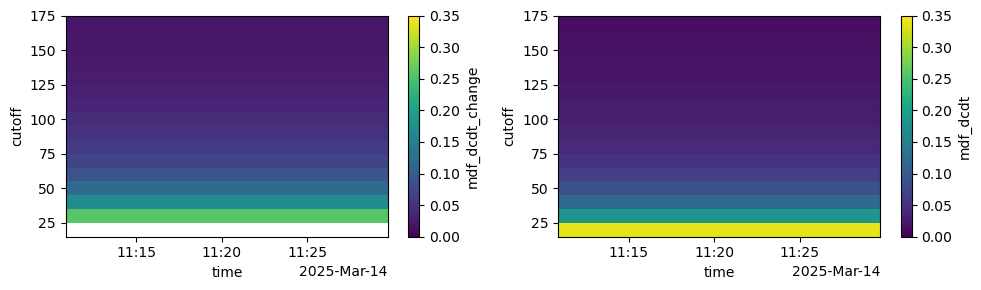

In [46]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
expected_ds['mdf_dcdt_change'].plot(ax=ax[0],vmin=0, vmax=0.35)
expected_ds['mdf_dcdt'].plot(ax=ax[1], vmin=0, vmax=0.35)
fig.tight_layout()


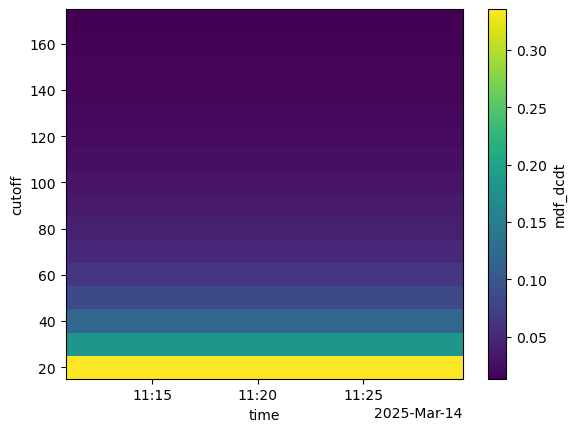

In [47]:
expected_ds['mdf_dcdt'].plot()

In [48]:
np.unique(expected_ds['d_startpoint'].values)

array([  0,  30,  60,  90, 150, 170])

In [49]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:       (time: 1080, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 9kB 2025-03-14T11:10:54 ... 2025-03-1...
  * deadband      (deadband) int32 24B 0 10 20 30 40 50
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 829kB ...
    dcdt(linear)  (time, cutoff, deadband) float64 829kB ...
    AIC(HM)       (time, cutoff, deadband) float64 829kB ...
    AIC(linear)   (time, cutoff, deadband) float64 829kB ...
    RMSE(HM)      (time, cutoff, deadband) float64 829kB ...
    RMSE(linear)  (time, cutoff, deadband) float64 829kB ...

In [50]:
np.unique(ds['dcdt(HM)'])

array([8.63977486e-10, 9.64732012e-05, 5.99927833e-03, ...,
       6.30262354e+82,            inf,            nan])

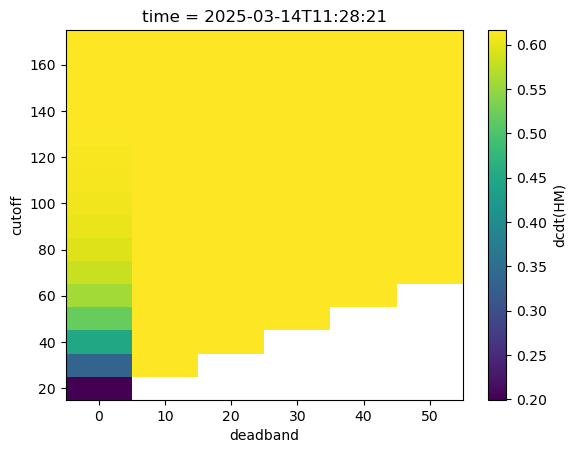

In [51]:
ds.isel(time=1000)['dcdt(HM)'].plot()

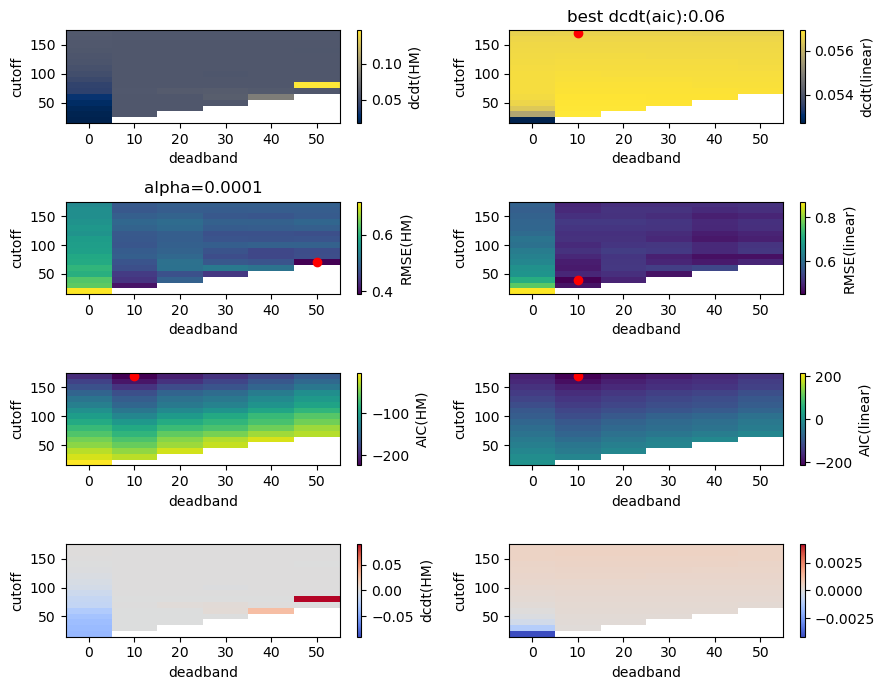

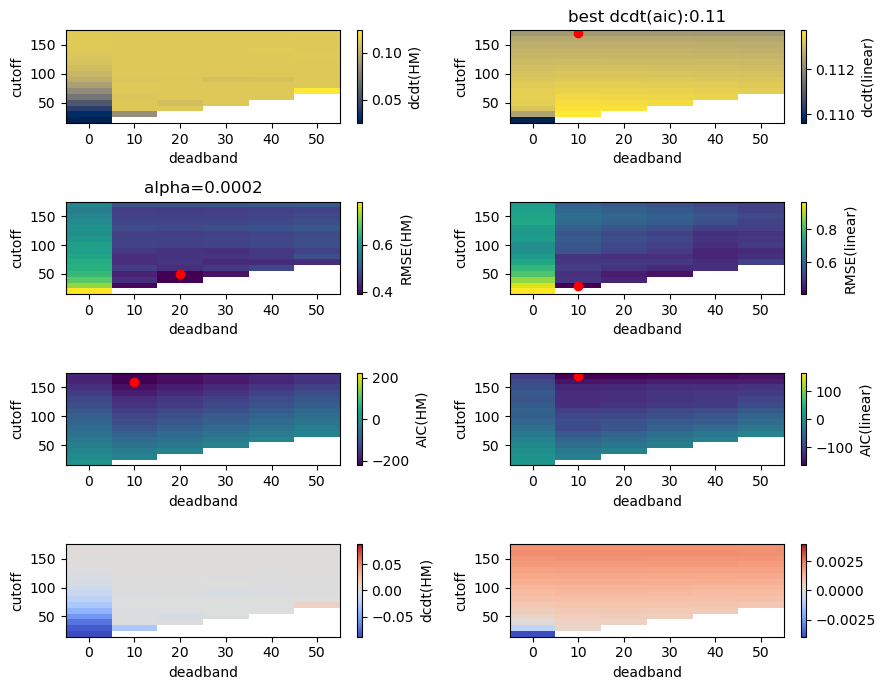

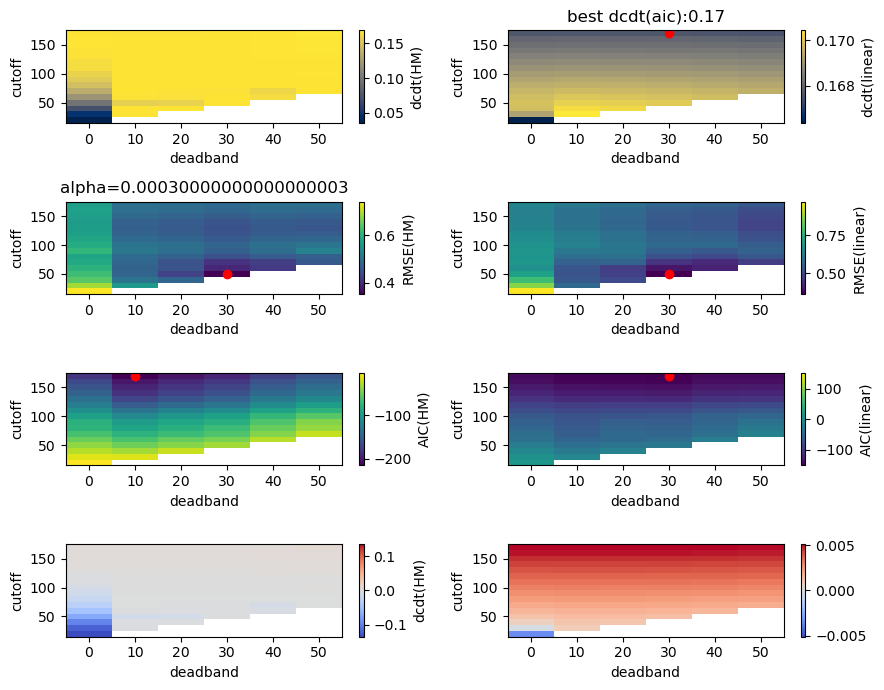

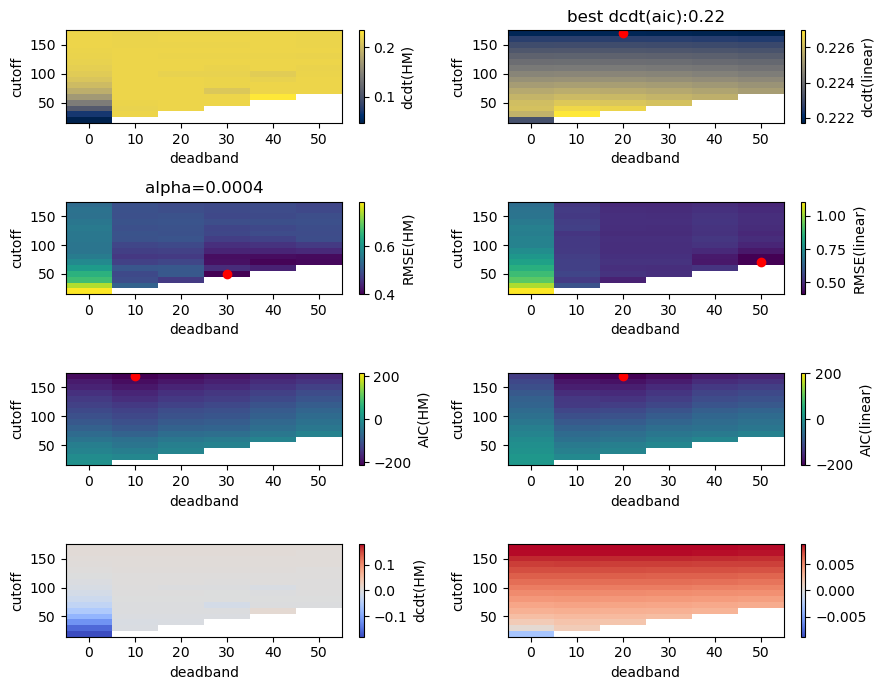

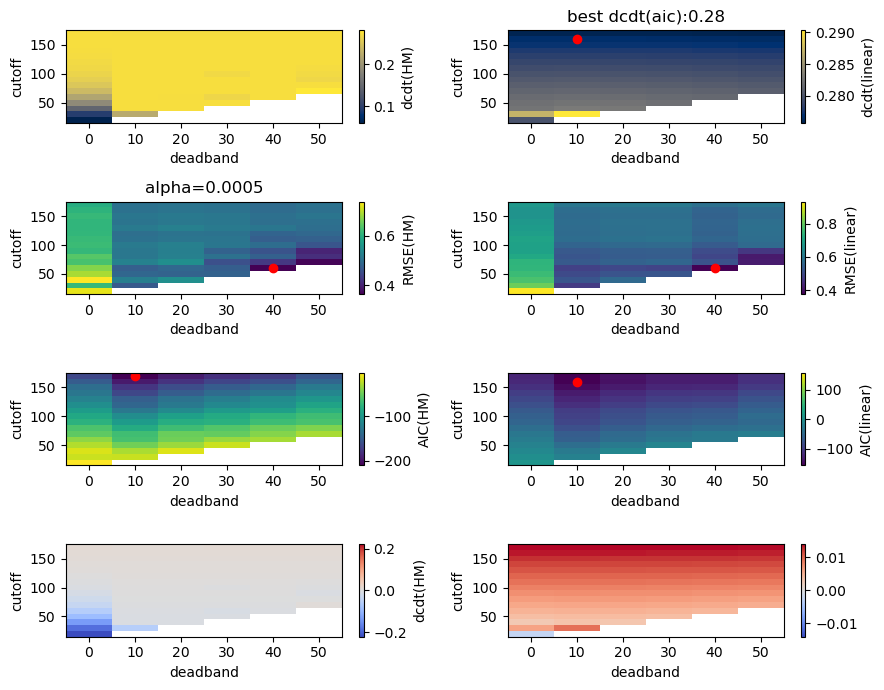

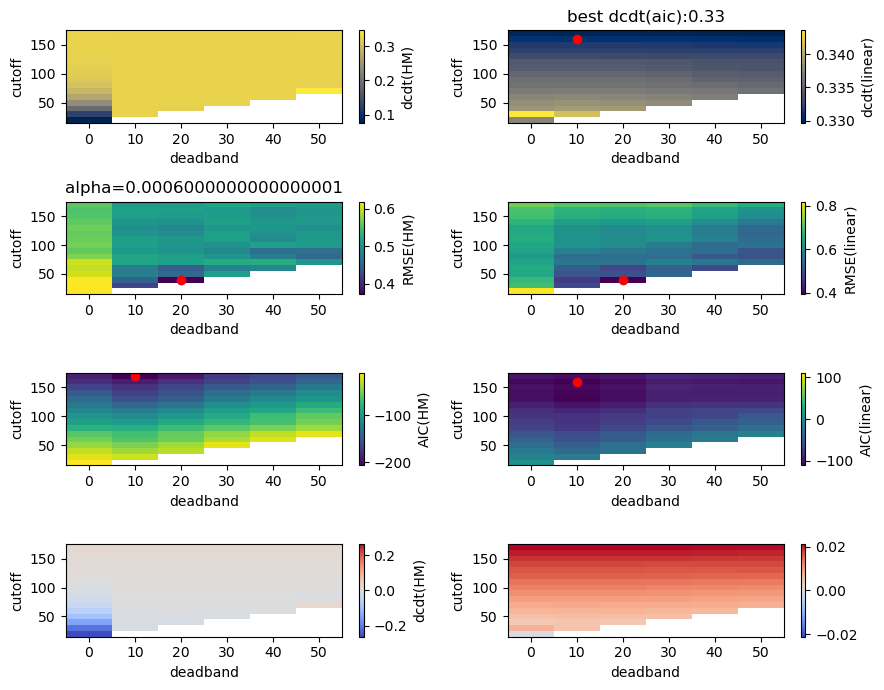

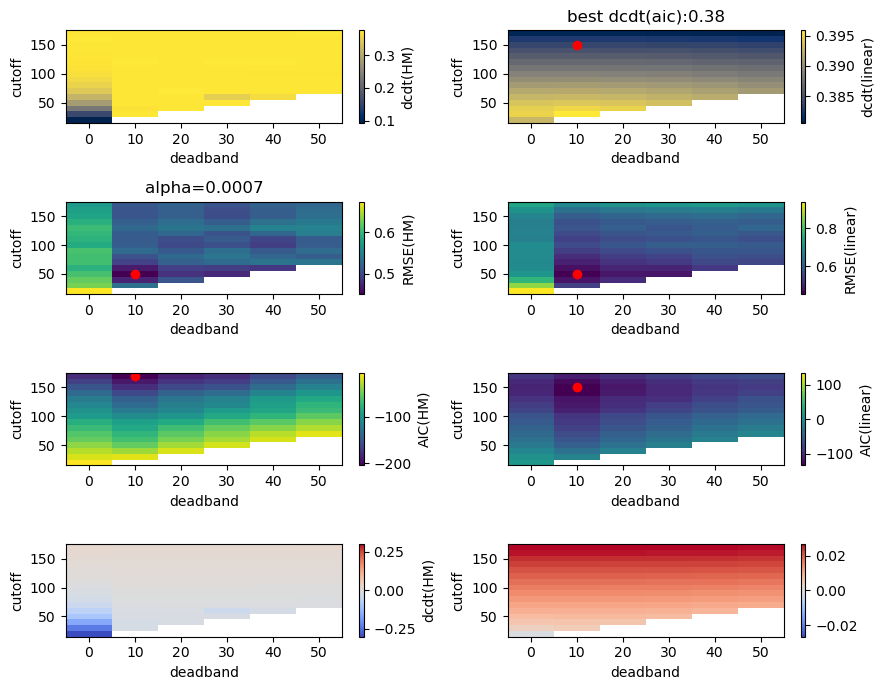

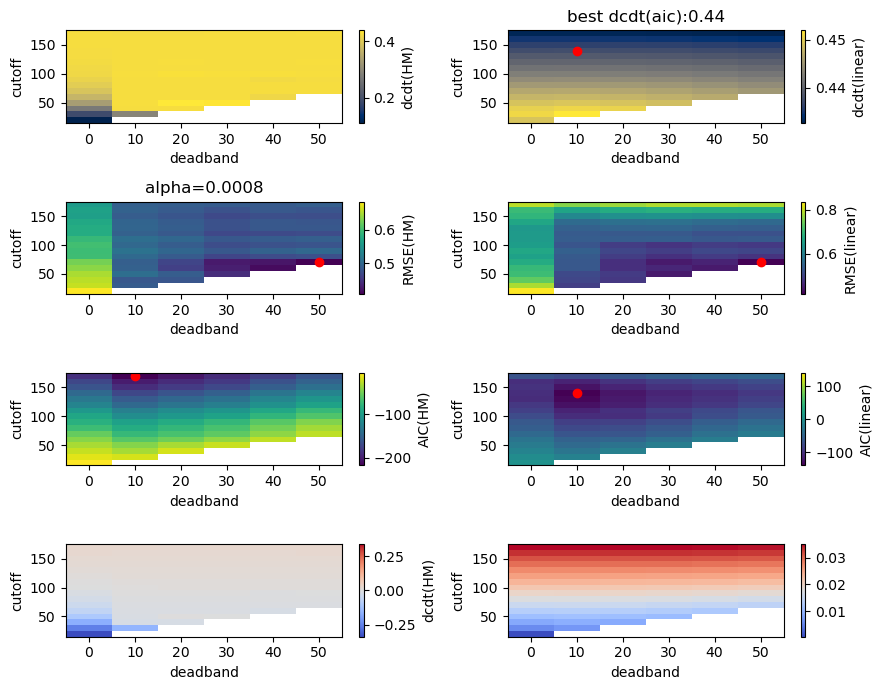

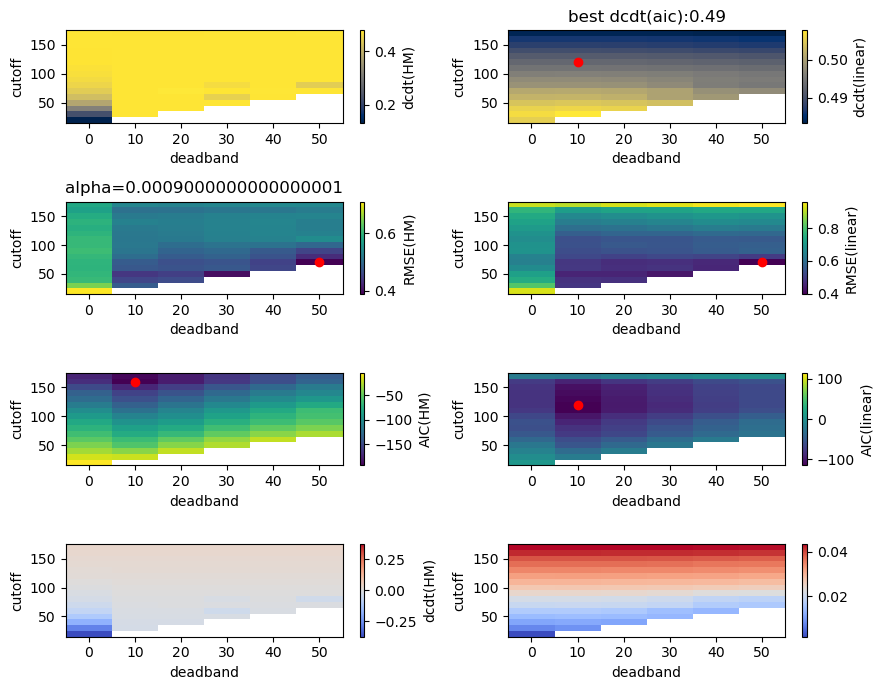

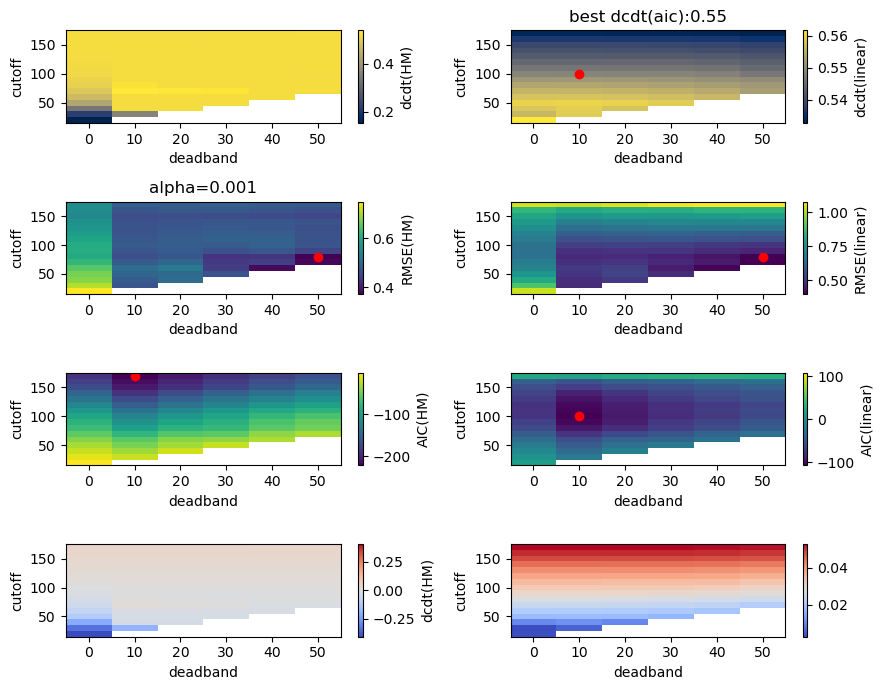

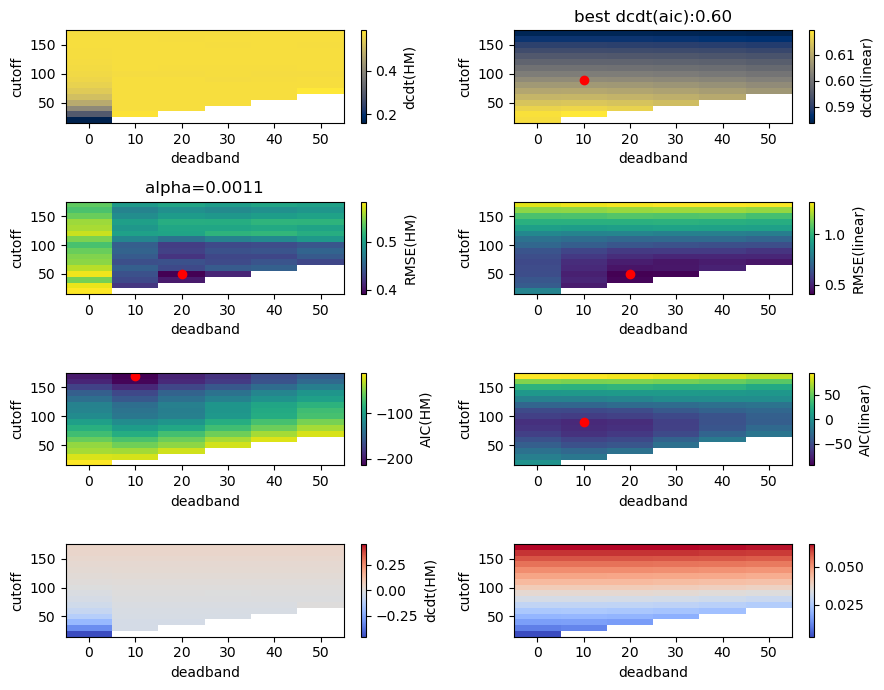

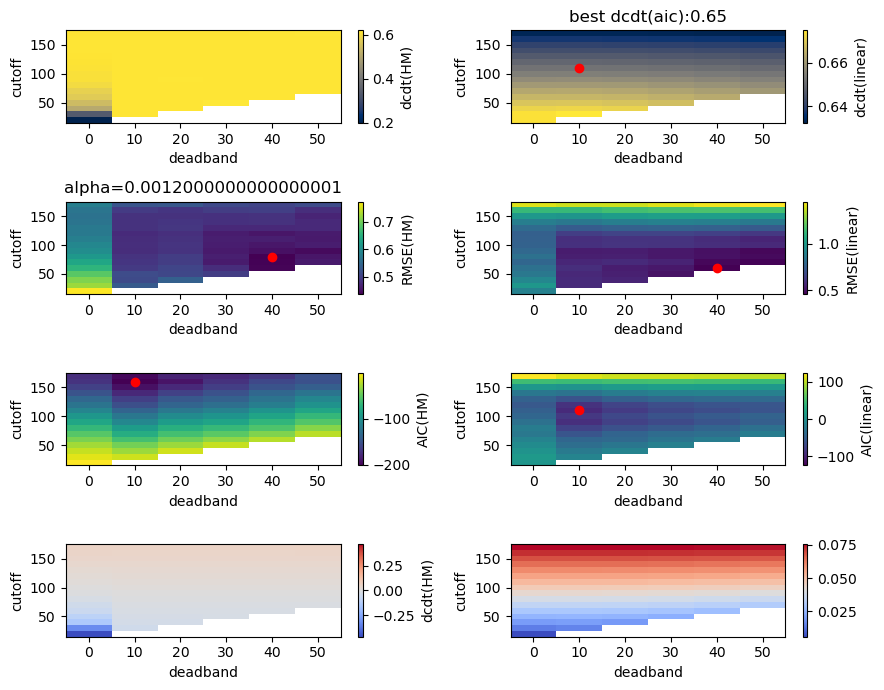

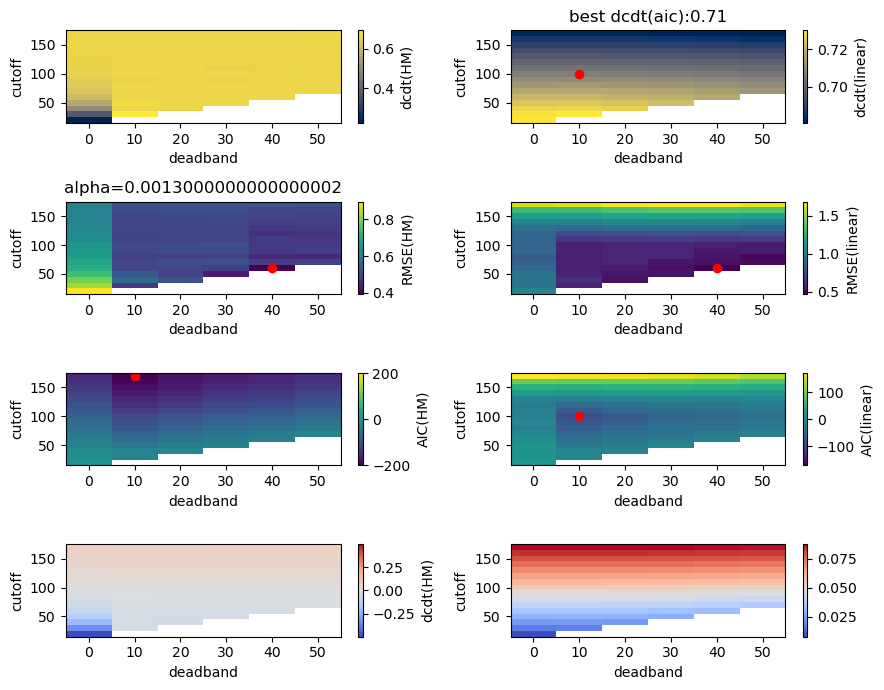

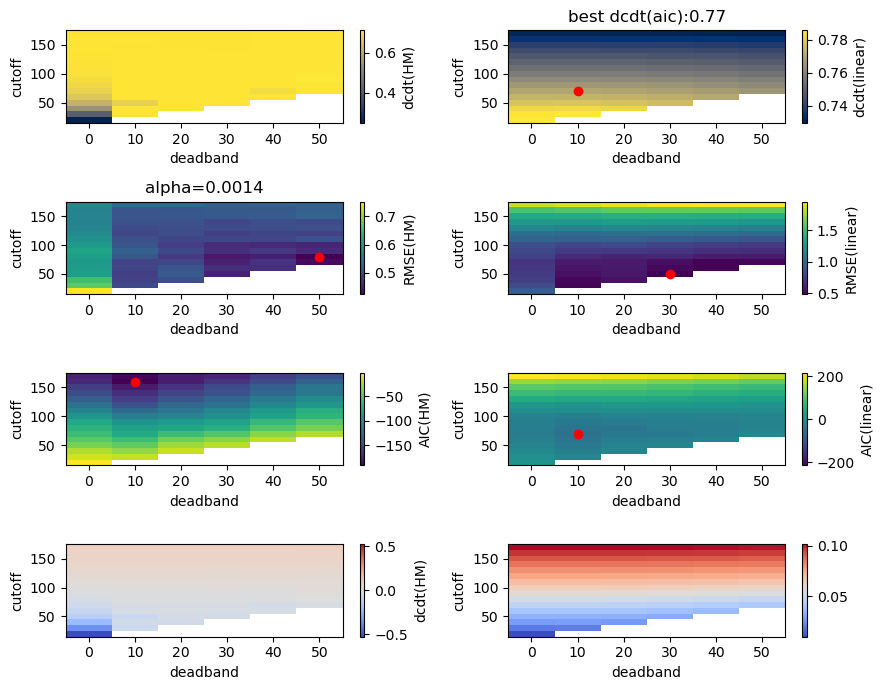

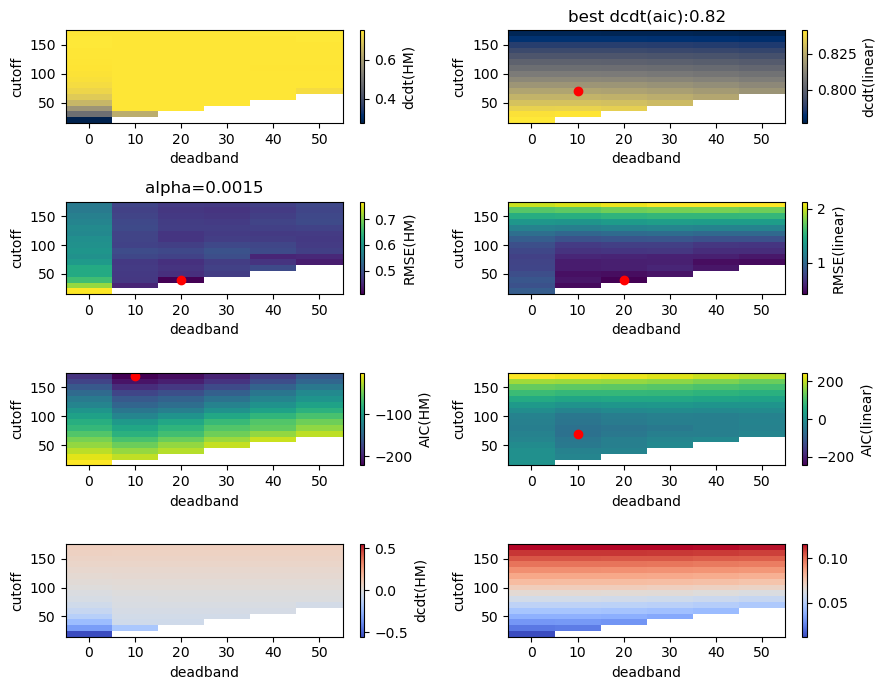

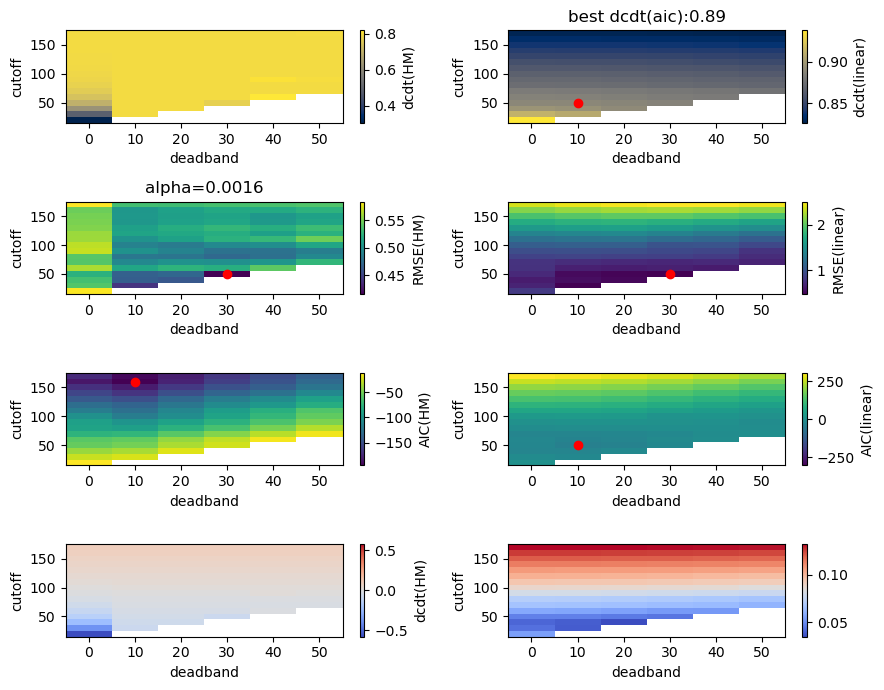

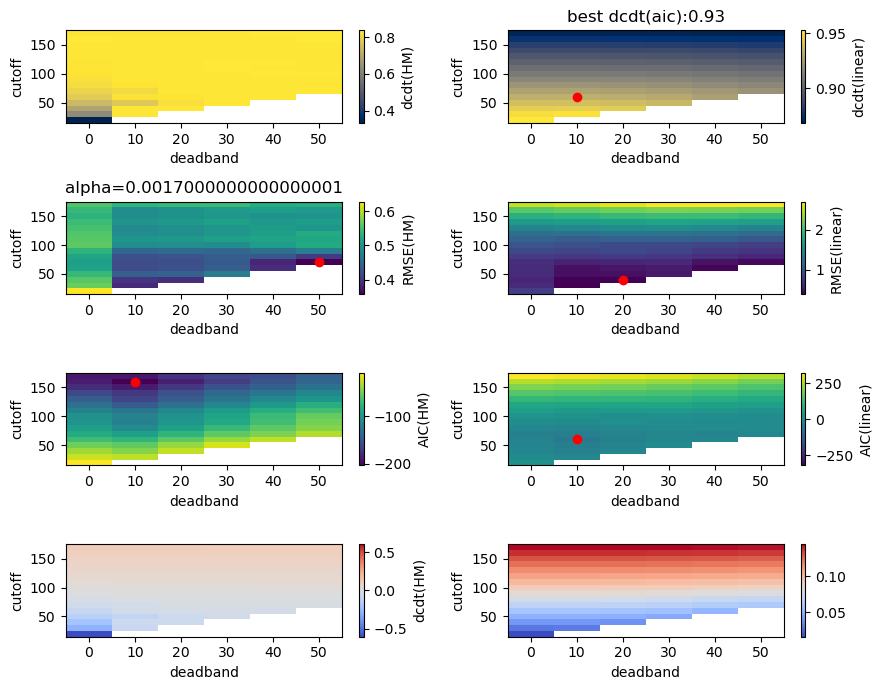

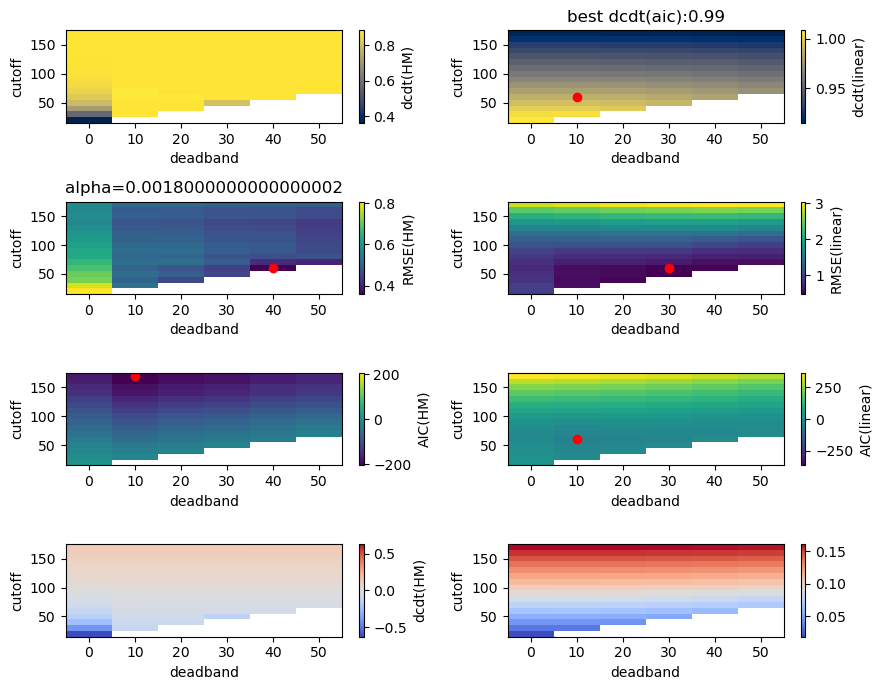

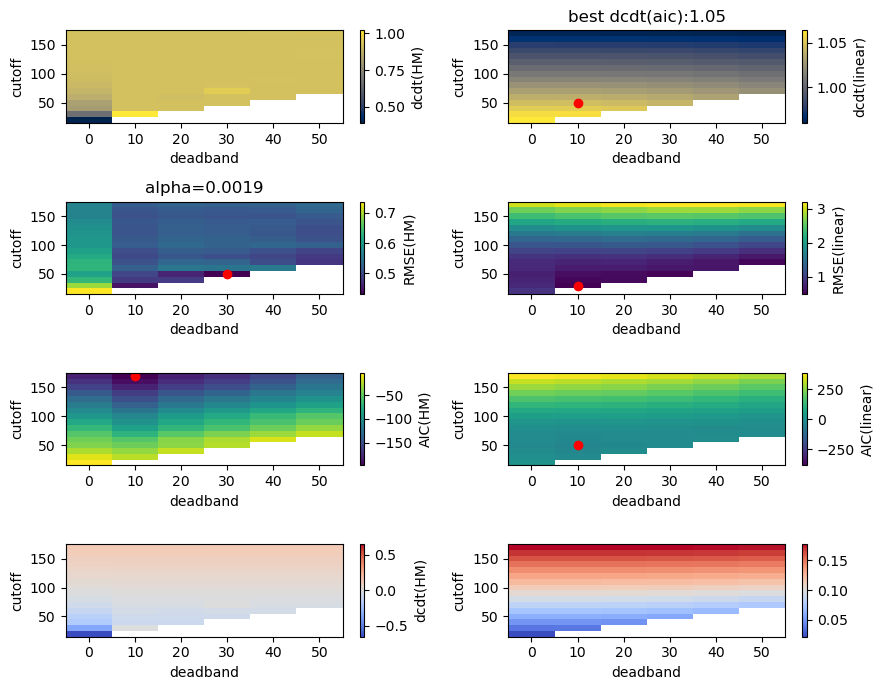

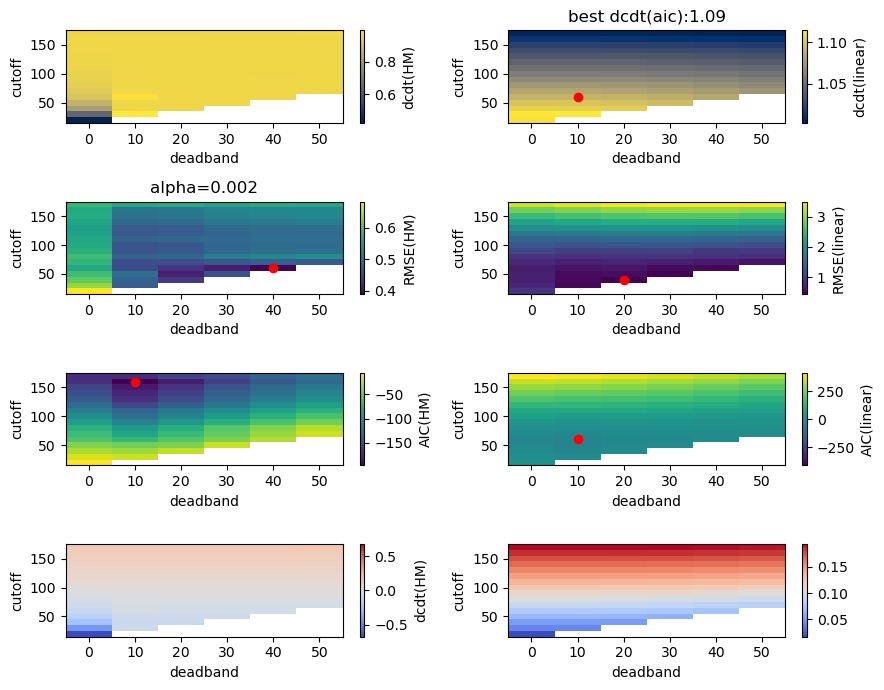

In [52]:
for alpha in np.unique(expected_ds['alpha'].values):
    # print(d_startpoint)
    # d_startpoint = 20

    fig, ax = plt.subplots(4,2, figsize=(9,7))
    
    time_selection = expected_ds.where((expected_ds['alpha'] == alpha)&(expected_ds['d_startpoint']==150), drop=True).time
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    ds.sel(time=time_selection)['dcdt(HM)'].median(dim=['time']).plot(ax=ax[0,0], cmap='cividis')
    ds.sel(time=time_selection)['dcdt(linear)'].median(dim=['time']).plot(ax=ax[0,1], cmap='cividis')


    ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).plot(ax=ax[1,0], cmap='viridis')
    ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).plot(ax=ax[1,1], cmap='viridis')

    ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).plot(ax=ax[2,0], cmap='viridis')
    ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).plot(ax=ax[2,1], cmap='viridis')

    # ax[2,0].scatter(ds.sel(time=time_selection)['AIC(HM)'].argmin(dim=['time']), ds.sel(time=time_selection)['AIC(HM)'].min(dim=['time']), color='red')
    # ax[2,0].scatter(20,100, color='red')
    # try:
    aic_argmin_HM = ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    aic_argmin_linear = ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    rmse_argmin_HM = ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    rmse_argmin_linear = ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])





    ax[2,0].scatter(deadband_coords[aic_argmin_HM['deadband']], 
                    cutoff_coords[aic_argmin_HM['cutoff']], color='red')
    ax[2,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    ax[1,0].scatter(deadband_coords[rmse_argmin_HM['deadband']],
                    cutoff_coords[rmse_argmin_HM['cutoff']], color='red')
    ax[1,1].scatter(deadband_coords[rmse_argmin_linear['deadband']],
                    cutoff_coords[rmse_argmin_linear['cutoff']], color='red')


    (ds.sel(time=time_selection)['dcdt(HM)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,0], cmap='coolwarm')
    (ds.sel(time=time_selection)['dcdt(linear)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,1], cmap='coolwarm')

    ax[0,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    
    dcdt_linear_minAIC = ds.sel(time=time_selection, 
                                deadband=deadband_coords[aic_argmin_linear['deadband']],
                                cutoff=cutoff_coords[aic_argmin_linear['cutoff']])['dcdt(linear)'].median(dim=['time']).values
    
    ax[0,1].set_title(f'best dcdt(aic):{dcdt_linear_minAIC:.2f}')


    ax[1,0].set_title(f'alpha={alpha}')
    fig.tight_layout()
    fig.show()
    # break